# MIT-BIH ECG Beat Classification (Patient-Level Split)

This notebook rebuilds the multi-class CNN pipeline with adaptive preprocessing, leakage-safe splits, class rebalancing, and macro-F1 monitoring. Run cells sequentially to train directly from `X.npy` / `y.npy`.



**Workflow**
- Imports, config, and reproducibility controls
- Load beats + patient metadata / sampling rates
- Filtering, wavelet denoising, and beat-quality gating
- Patient-aware train/val/test split, normalization, and class weights
- tf.data pipeline with rejection-resampling + augmentations
- Residual CNN with squeeze-excite and attention, macro-F1 callback, and rich evaluation



In [19]:
from __future__ import annotations

import math
import random
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import tensorflow as tf
from scipy.signal import butter, filtfilt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm.auto import tqdm

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 4)})

CONFIG = {
    "paths": {
        "data_dir": Path("."),
        "x_file": "X.npy",
        "y_file": "y.npy",
        "patient_metadata": [
            "beat_metadata.parquet",
            "beat_metadata.csv",
            "patient_ids.npy",
            "record_ids.npy",
        ],
        "sampling_rates_file": "beat_sampling_rates.npy",
        "checkpoint_dir": Path("checkpoints/cardiology_notebook"),
        "require_patient_ids": False,
    },
    "split": {
        "test_size": 0.2,
        "val_size": 0.15,
        "group_split_seed": SEED,
    },
    "preprocessing": {
        "bandpass_low": 0.5,
        "bandpass_high": 40.0,
        "bandpass_order": 4,
        "default_fs": 360,
        "wavelet": "db6",
        "wavelet_level": 3,
        "wavelet_threshold_scale": 0.8,
        "normalization_mode": "leadwise",
        "min_peak_to_peak": 0.05,
        "max_peak_to_peak": 8.0,
        "max_abs_threshold": 10.0,
    },
    "augmentation": {
        "enabled": False,
        "prob": 0.8,
        "max_time_shift": 6,
        "noise_std": 0.02,
        "scaling_range": 0.08,
        "dropout_prob": 0.1,
    },
    "training": {
        "batch_size": 192,
        "epochs": 12,
        "learning_rate": 1e-3,
        "label_smoothing": 0.0,
        "patience": 10,
        "sanity_check_size": 256,
        "sanity_check_epochs": 3,
        "run_sanity_check": True,
        "max_steps_per_epoch": 60,
        "shuffle_buffer": 5000,
        "use_rejection_resample": False,
        "train_subset_size": 6000,
    },
    "model": {
        "base_filters": 48,
        "width_scale": 0.5,
        "filter_multipliers": [1.0, 2.0, 2.0, 4.0],
        "dilations": [1, 2, 4, 8],
        "stem_kernel": 5,
        "attention_heads": 4,
        "attention_key_dim": 32,
        "use_attention": False,
        "dense_units": [192, 96],
        "dense_dropouts": [0.25, 0.15],
    },
}

CONFIG["paths"]["checkpoint_dir"].mkdir(parents=True, exist_ok=True)

In [20]:
# Load beats and labels
paths = CONFIG["paths"]
data_dir = paths["data_dir"]
X_path = data_dir / paths["x_file"]
y_path = data_dir / paths["y_file"]
X_raw = np.load(X_path).astype(np.float32)
y_raw = np.load(y_path, allow_pickle=True).astype(str)
print(f"Loaded beats: {X_raw.shape}, labels: {y_raw.shape}")

# Derive patient/record IDs if metadata is available
patient_ids = None
for candidate in paths["patient_metadata"]:
    meta_path = data_dir / candidate
    if not meta_path.exists():
        continue
    if meta_path.suffix in {".parquet", ".pq"}:
        meta_df = pd.read_parquet(meta_path)
    elif meta_path.suffix == ".csv":
        meta_df = pd.read_csv(meta_path)
    elif meta_path.suffix in {".npy", ".npz"}:
        arr = np.load(meta_path, allow_pickle=True)
        if arr.shape[0] == len(X_raw):
            patient_ids = arr.astype(str)
            print(f"Loaded patient IDs from {meta_path}")
            break
        continue
    else:
        continue
    for col in ("patient_id", "record_id", "record", "subject_id"):
        if col in meta_df.columns and len(meta_df[col]) == len(X_raw):
            patient_ids = meta_df[col].astype(str).to_numpy()
            print(f"Loaded patient IDs from {meta_path} (column {col})")
            break
    if patient_ids is not None:
        break

if patient_ids is None:
    if paths.get("require_patient_ids", False):
        raise FileNotFoundError("Patient metadata required but not found.")
    warnings.warn(
        "Patient metadata missing; generating deterministic pseudo IDs. Replace with real IDs to avoid leakage.",
        RuntimeWarning,
    )
    chunk = max(len(X_raw) // 25, 1500)
    patient_ids = np.repeat(np.arange((len(X_raw) + chunk - 1) // chunk), chunk)[: len(X_raw)]
    patient_ids = patient_ids.astype(str)

# Sampling rates per beat (defaults if file absent)
sample_rates_path = data_dir / paths["sampling_rates_file"]
if sample_rates_path.exists():
    sample_rates = np.load(sample_rates_path).astype(np.float32)
    if sample_rates.shape[0] != len(X_raw):
        sample_rates = np.full(len(X_raw), CONFIG["preprocessing"]["default_fs"], dtype=np.float32)
else:
    sample_rates = np.full(len(X_raw), CONFIG["preprocessing"]["default_fs"], dtype=np.float32)

Loaded beats: (112551, 301, 2), labels: (112551,)


/var/folders/1p/_gy22mqs0zlds0nfpr3v4t5c0000gn/T/ipykernel_42934/3747944710.py:40: RuntimeWarning: Patient metadata missing; generating deterministic pseudo IDs. Replace with real IDs to avoid leakage.
  warnings.warn(


In [21]:
# Adaptive band-pass filtering + wavelet denoising
pre_cfg = CONFIG["preprocessing"]
processed = np.empty_like(X_raw, dtype=np.float32)
filter_cache = {}

for idx in tqdm(range(len(X_raw)), desc="Filtering + wavelet denoise"):
    beat = X_raw[idx]
    fs = float(sample_rates[idx])
    nyq = 0.5 * fs
    low = max(pre_cfg["bandpass_low"] / nyq, 1e-4)
    high = min(pre_cfg["bandpass_high"] / nyq, 0.999)
    key = (round(low, 5), round(high, 5), pre_cfg["bandpass_order"])
    if key not in filter_cache:
        filter_cache[key] = butter(pre_cfg["bandpass_order"], [low, high], btype="band")
    b, a = filter_cache[key]
    filtered = filtfilt(b, a, beat, axis=0)

    coeffs = pywt.wavedec(filtered, pre_cfg["wavelet"], level=pre_cfg["wavelet_level"], axis=0)
    detail = coeffs[-1]
    sigma = np.median(np.abs(detail)) / 0.6745 + 1e-9
    threshold = pre_cfg["wavelet_threshold_scale"] * sigma * math.sqrt(2 * math.log(filtered.shape[0]))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode="soft") for c in coeffs[1:]]
    reconstructed = pywt.waverec(denoised_coeffs, pre_cfg["wavelet"], axis=0)
    processed[idx] = reconstructed[: beat.shape[0]].astype(np.float32)

ptp = np.ptp(processed, axis=1)
max_ptp = ptp.max(axis=1)
max_abs = np.max(np.abs(processed), axis=(1, 2))
quality_mask = (
    (max_ptp >= pre_cfg["min_peak_to_peak"]) &
    (max_ptp <= pre_cfg["max_peak_to_peak"]) &
    (max_abs <= pre_cfg["max_abs_threshold"])
)
if quality_mask.sum() < int(0.2 * len(processed)):
    warnings.warn(
        "Quality gate would remove >80% of beats; keeping all samples. Adjust thresholds if needed.",
        RuntimeWarning,
    )
    quality_mask = np.ones(len(processed), dtype=bool)

X_clean = processed[quality_mask]
y_clean = y_raw[quality_mask]
patient_ids_clean = patient_ids[quality_mask]
sample_rates_clean = sample_rates[quality_mask]
print(f"Kept {len(X_clean)} / {len(X_raw)} beats after cleaning")

Filtering + wavelet denoise: 100%|██████████| 112551/112551 [01:50<00:00, 1020.98it/s]
/var/folders/1p/_gy22mqs0zlds0nfpr3v4t5c0000gn/T/ipykernel_42934/480781227.py:35: RuntimeWarning: Quality gate would remove >80% of beats; keeping all samples. Adjust thresholds if needed.
  warnings.warn(


Kept 112551 / 112551 beats after cleaning


In [22]:
# Encode labels and form patient-aware splits
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clean)
num_classes = len(label_encoder.classes_)

split_cfg = CONFIG["split"]
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=split_cfg["test_size"],
    random_state=split_cfg["group_split_seed"],
)
try:
    train_val_idx, test_idx = next(gss.split(np.zeros_like(y_encoded), y_encoded, patient_ids_clean))
    inner = GroupShuffleSplit(
        n_splits=1,
        test_size=split_cfg["val_size"],
        random_state=split_cfg["group_split_seed"] + 1,
    )
    train_rel, val_rel = next(
        inner.split(
            np.zeros_like(train_val_idx),
            y_encoded[train_val_idx],
            patient_ids_clean[train_val_idx],
        )
    )
    train_idx = train_val_idx[train_rel]
    val_idx = train_val_idx[val_rel]
except ValueError as err:
    warnings.warn(
        f"Group-aware split failed ({err}). Using deterministic chunk split; ensure patient IDs are valid.",
        RuntimeWarning,
    )
    n = len(y_encoded)
    train_val_end = max(int((1 - split_cfg["test_size"]) * n), 1)
    train_val_idx = np.arange(train_val_end)
    test_idx = np.arange(train_val_end, n)
    val_len = max(int(split_cfg["val_size"] * len(train_val_idx)), 1)
    val_idx = train_val_idx[-val_len:]
    train_idx = train_val_idx[:-val_len]

X_train, X_val, X_test = X_clean[train_idx], X_clean[val_idx], X_clean[test_idx]
y_train, y_val, y_test = y_encoded[train_idx], y_encoded[val_idx], y_encoded[test_idx]
patient_train = patient_ids_clean[train_idx]
patient_val = patient_ids_clean[val_idx]
patient_test = patient_ids_clean[test_idx]

print(
    f"Split sizes — train: {len(X_train)} (patients: {len(np.unique(patient_train))}), "
    f"val: {len(X_val)} (patients: {len(np.unique(patient_val))}), "
    f"test: {len(X_test)} (patients: {len(np.unique(patient_test))})"
)

# Lead-wise normalization using training statistics
if CONFIG["preprocessing"]["normalization_mode"] == "per_beat_zscore":
    def _z(arr):
        mean = arr.mean(axis=1, keepdims=True)
        std = arr.std(axis=1, keepdims=True) + 1e-7
        return (arr - mean) / std
    X_train = _z(X_train)
    X_val = _z(X_val)
    X_test = _z(X_test)
else:
    train_mean = X_train.reshape(-1, X_train.shape[-1]).mean(axis=0).reshape(1, 1, -1)
    train_std = X_train.reshape(-1, X_train.shape[-1]).std(axis=0).reshape(1, 1, -1) + 1e-7
    X_train = (X_train - train_mean) / train_std
    X_val = (X_val - train_mean) / train_std
    X_test = (X_test - train_mean) / train_std

subset_size = CONFIG["training"].get("train_subset_size")
if subset_size and subset_size < len(X_train):
    print(f"[Stage] Using fast-mode subset of {subset_size} beats (was {len(X_train)}).")
    chosen = np.random.choice(len(X_train), size=subset_size, replace=False)
    X_train = X_train[chosen]
    y_train = y_train[chosen]

# Class weights for severe imbalance
train_class_counts = np.bincount(y_train, minlength=num_classes)
unique_classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_train)
class_weights = {int(cls): float(w) for cls, w in zip(unique_classes, weights)}
max_weight = max(class_weights.values()) if len(class_weights) else 1.0
for cls_id in range(num_classes):
    class_weights.setdefault(cls_id, max_weight)
print("Class weights:", class_weights)

Split sizes — train: 72033 (patients: 17), val: 13506 (patients: 3), test: 27012 (patients: 6)
[Stage] Using fast-mode subset of 6000 beats (was 72033).
Class weights: {1: 0.13084438241451501, 2: 3.865979381443299, 3: 24.193548387096776, 4: 41.666666666666664, 5: 83.33333333333333, 6: 62.5, 7: 375.0, 8: 375.0, 0: 375.0, 9: 375.0, 10: 375.0}


In [23]:

# Build tf.data pipelines with optional class balancing and augmentations
aug_cfg = CONFIG["augmentation"]
train_cfg = CONFIG["training"]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

shuffle_buffer = min(len(X_train), train_cfg.get("shuffle_buffer", len(X_train)))
if shuffle_buffer > 1:
    train_ds = train_ds.shuffle(shuffle_buffer, seed=SEED, reshuffle_each_iteration=True)

if train_cfg.get("use_rejection_resample", False):
    counts = np.bincount(y_train, minlength=num_classes).astype(np.float64)
    available = counts > 0
    initial_dist = counts / counts.sum()
    target_dist = np.where(available, 1.0, 0.0)
    target_dist = target_dist / target_dist.sum()
    train_ds = train_ds.apply(
        tf.data.experimental.rejection_resample(
            class_func=lambda features, label: label,
            target_dist=target_dist,
            initial_dist=initial_dist,
            seed=SEED,
        )
    )
    train_ds = train_ds.map(lambda extra, data: data)


def augment_example(signal, label):
    if not aug_cfg["enabled"]:
        return signal, label

    def _augment():
        x = signal
        shift = tf.random.uniform([], -aug_cfg["max_time_shift"], aug_cfg["max_time_shift"] + 1, dtype=tf.int32)
        x = tf.roll(x, shift=shift, axis=0)
        noise = tf.random.normal(tf.shape(x), stddev=aug_cfg["noise_std"])
        scale = 1.0 + tf.random.uniform([tf.shape(x)[-1]], -aug_cfg["scaling_range"], aug_cfg["scaling_range"])
        x = x * scale
        dropout_mask = tf.cast(tf.random.uniform([tf.shape(x)[0], 1]) > aug_cfg["dropout_prob"], tf.float32)
        x = x * dropout_mask + noise
        return x

    return tf.cond(
        tf.less(tf.random.uniform([], 0, 1), aug_cfg["prob"]),
        _augment,
        lambda: signal,
    ), label


train_ds = train_ds.map(augment_example, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.repeat().batch(train_cfg["batch_size"]).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(train_cfg["batch_size"]).prefetch(tf.data.AUTOTUNE)


In [24]:

# Build CNN with residual + squeeze-excite blocks (attention optional)
model_cfg = CONFIG.get("model", {})
width_scale = model_cfg.get("width_scale", 1.0)
base_filters = model_cfg.get("base_filters", 64)
filter_multipliers = model_cfg.get("filter_multipliers", [1.0, 2.0, 2.0, 4.0])
dilations = model_cfg.get("dilations", [1, 2, 4, 8])
filters = [max(16, int(round(base_filters * width_scale * mult))) for mult in filter_multipliers[: len(dilations)]]
dense_units = model_cfg.get("dense_units", [256, 128])
dense_dropouts = model_cfg.get("dense_dropouts", [0.4, 0.3])
if len(dense_dropouts) < len(dense_units):
    dense_dropouts = dense_dropouts + [dense_dropouts[-1]] * (len(dense_units) - len(dense_dropouts))

input_shape = X_train.shape[1:]
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv1D(filters[0], model_cfg.get("stem_kernel", 7), padding="same", strides=1)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

for filt, dilation in zip(filters, dilations):
    shortcut = x
    kernel_size = 5 if filt < 256 else 3
    y = tf.keras.layers.SeparableConv1D(filt, kernel_size, padding="same", dilation_rate=dilation)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)
    y = tf.keras.layers.SeparableConv1D(filt, kernel_size, padding="same", dilation_rate=dilation)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if shortcut.shape[-1] != filt:
        shortcut = tf.keras.layers.Conv1D(filt, 1, padding="same")(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    y = tf.keras.layers.Add()([shortcut, y])
    y = tf.keras.layers.Activation("relu")(y)
    y = tf.keras.layers.SpatialDropout1D(0.1)(y)
    squeeze = tf.keras.layers.GlobalAveragePooling1D()(y)
    squeeze = tf.keras.layers.Dense(max(filt // 8, 4), activation="relu")(squeeze)
    squeeze = tf.keras.layers.Dense(filt, activation="sigmoid")(squeeze)
    squeeze = tf.keras.layers.Reshape((1, filt))(squeeze)
    x = tf.keras.layers.Multiply()([y, squeeze])

if model_cfg.get("use_attention", True):
    attn = tf.keras.layers.MultiHeadAttention(
        num_heads=model_cfg.get("attention_heads", 4),
        key_dim=model_cfg.get("attention_key_dim", 32),
        dropout=0.1,
    )(x, x)
    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
for units, drop in zip(dense_units, dense_dropouts):
    scaled_units = max(32, int(round(units * width_scale)))
    x = tf.keras.layers.Dense(scaled_units, activation="relu")(x)
    if drop:
        x = tf.keras.layers.Dropout(drop)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_template = tf.keras.Model(inputs, outputs, name="cardiology_cnn")



[Stage] Running sanity-check overfit subset...
Sanity-check accuracy after 8 epochs: 0.957
[Stage] Sanity-check complete.

[Stage] Setting up full training run...

[Stage] Starting full training...
Epoch 1/80
[Epoch 1/80] val_macro_f1=0.0001 | val_weighted_f1=0.0000 | -1 F1=0.00, 8 F1=0.00, 9 F1=0.00

Epoch 1: val_macro_f1 improved from None to 0.00011, saving model to checkpoints/cardiology_notebook/best_val_macro_f1.keras
63/63 - 103s - 2s/step - accuracy: 0.0945 - loss: 2.4960 - top3_acc: 0.7098 - val_accuracy: 5.9233e-04 - val_loss: 2.2216 - val_top3_acc: 0.9662 - val_macro_f1: 1.0763e-04 - val_weighted_f1: 7.0129e-07 - learning_rate: 0.0010
Epoch 2/80
[Epoch 2/80] val_macro_f1=0.0889 | val_weighted_f1=0.9363 | -1 F1=0.00, 8 F1=0.00, 9 F1=0.00

Epoch 2: val_macro_f1 improved from 0.00011 to 0.08892, saving model to checkpoints/cardiology_notebook/best_val_macro_f1.keras
63/63 - 70s - 1s/step - accuracy: 0.2751 - loss: 2.1537 - top3_acc: 0.8182 - val_accuracy: 0.9572 - val_loss: 2.

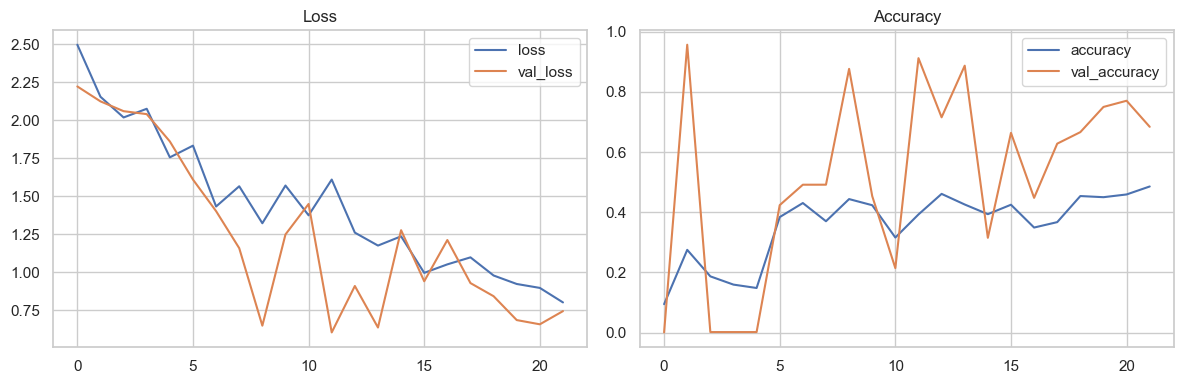


[Stage] Evaluating trained model...
[Stage] Evaluating on Validation split...

Validation macro-F1: 0.1697 | weighted-F1: 0.9409
              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000         1
           0     0.9875    0.9268    0.9562     12928
           1     0.8481    0.8292    0.8385       404
           2     0.1739    0.0354    0.0588       113
           3     0.0037    0.0833    0.0070        24
           4     0.0000    0.0000    0.0000         6
           5     0.0000    0.0000    0.0000         8
           6     0.0029    0.1667    0.0058         6
           7     0.0000    0.0000    0.0000        10
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         3

    accuracy                         0.9125     13506
   macro avg     0.1833    0.1856    0.1697     13506
weighted avg     0.9720    0.9125    0.9409     13506



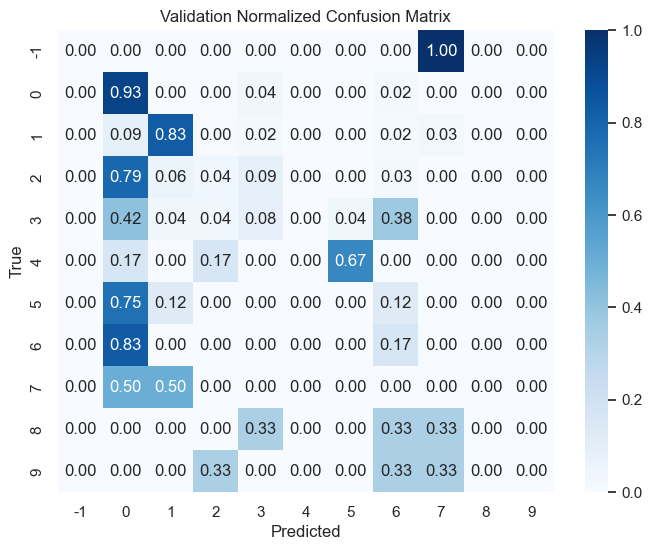

[Stage] Evaluating on Test split...

Test macro-F1: 0.0754 | weighted-F1: 0.6692
              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000         1
           0     0.9970    0.5071    0.6723     26887
           1     0.0006    0.0244    0.0012        41
           2     0.0012    0.0909    0.0024        55
           3     0.0015    0.0741    0.0030        27
           4     0.0000    0.0000    0.0000         0
           5     0.0000    0.0000    0.0000         1
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.5050     27012
   macro avg     0.0909    0.0633    0.0617     27012
weighted avg     0.9924    0.5050    0.6692     27012



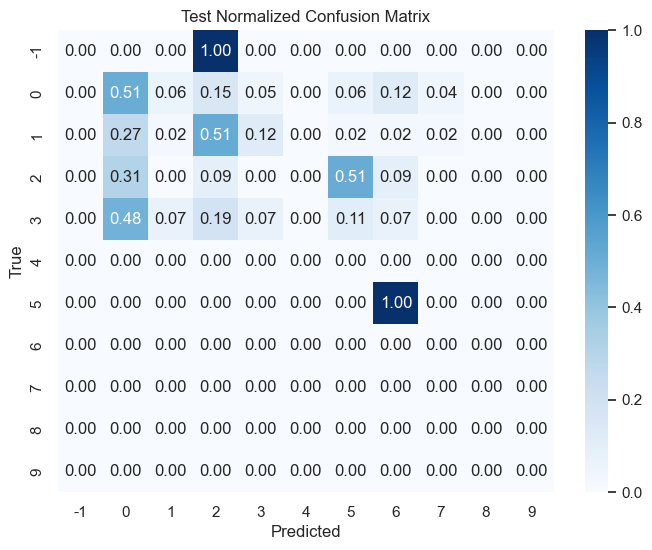

In [25]:

# Optional sanity-check overfit on a subset to ensure pipeline works
if training_cfg["run_sanity_check"]:
    print("\n[Stage] Running sanity-check overfit subset...")
    sample_size = min(training_cfg["sanity_check_size"], len(X_train))
    subset_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
    sanity_model = compile_fresh_model()
    history = sanity_model.fit(
        X_train[subset_idx],
        y_train[subset_idx],
        epochs=training_cfg["sanity_check_epochs"],
        batch_size=min(64, sample_size),
        verbose=0,
    )
    print(
        f"Sanity-check accuracy after {training_cfg['sanity_check_epochs']} epochs: {history.history['accuracy'][-1]:.3f}"
    )
    print("[Stage] Sanity-check complete.")

print("\n[Stage] Setting up full training run...")
model = compile_fresh_model()
macro_cb = MacroF1Callback(X_val, y_val, label_encoder, class_counts=train_class_counts)
checkpoint_path = paths["checkpoint_dir"] / "best_val_macro_f1.keras"
callbacks = [
    macro_cb,
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_macro_f1",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_macro_f1",
        patience=training_cfg["patience"],
        mode="max",
        restore_best_weights=True,
        verbose=1,
    ),
]

steps_per_epoch = max(int(np.ceil(len(X_train) / training_cfg["batch_size"])), 1)
max_steps = training_cfg.get("max_steps_per_epoch")
if max_steps:
    prev_steps = steps_per_epoch
    steps_per_epoch = max(1, min(steps_per_epoch, max_steps))
    if steps_per_epoch < prev_steps:
        print(f"[Stage] steps_per_epoch capped at {steps_per_epoch} (was {prev_steps}) for faster epochs.")
print("\n[Stage] Starting full training...")
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    epochs=training_cfg["epochs"],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2,
)
print("[Stage] Training complete.")

print("\n[Stage] Plotting training curves...")
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_df[["loss", "val_loss"]].plot(ax=axes[0])
history_df[["accuracy", "val_accuracy"]].plot(ax=axes[1])
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
plt.tight_layout()
plt.show()

print("\n[Stage] Evaluating trained model...")
for split_name, X_split, y_split in [
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]:
    print(f"[Stage] Evaluating on {split_name} split...")
    probs = model.predict(X_split, batch_size=256, verbose=0)
    preds = probs.argmax(axis=1)
    macro = f1_score(y_split, preds, average="macro")
    weighted = f1_score(y_split, preds, average="weighted")
    print(f"\n{split_name} macro-F1: {macro:.4f} | weighted-F1: {weighted:.4f}")
    print(
        classification_report(
            y_split,
            preds,
            labels=np.arange(num_classes),
            target_names=label_encoder.classes_.astype(str),
            digits=4,
            zero_division=0,
        )
    )
    cm = confusion_matrix(y_split, preds, labels=np.arange(num_classes), normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.title(f"{split_name} Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

